# 02_MARES_mooring_DATA-Analysis

### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units


import shapely
from shapely.geometry import Point
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# sys.path.append('../Libraries_functions/')
# from LIB_ASI_SIC_UniB import grab_ASI_SIC

# from LIB_geo_plot import *
# # from LIB_access_ERA5 import shift_bylons
# from LIB_PPdrift_NSIDC0116 import grab_icedrift_range

# path to own functions
sys.path.append('../')

import timeseries.vectors as vectors
import data_UniBremen.SIC as UNISIC


In [ ]:
def grab_atm(time_range, lat = 70.5 , lon = -140):
    
    # year1
    DS1 = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_{time_range.start.year}.nc')
    DS1.close()
    time_slice = slice(time_range.start, datetime(time_range.start.year, 12, 31, 23))
    DS1 = DS1.sel(latitude = lat, longitude = lon, time=time_slice)

    # year2
    DS2 = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_{time_range.stop.year}.nc')
    DS2.close()
    time_slice = slice(datetime(time_range.stop.year, 1, 1, 0), time_range.stop)
    DS2 = DS2.sel(latitude = lat, longitude = lon, time=time_slice)

    # combine
    ds4 = xr.concat([DS1, DS2], dim="time")
    
    return ds4
    

## Import data

In [2]:
# Save to file
df = pd.read_csv('./data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>}

In [329]:
#===============================================================

# 2016-2017
# time_range = slice(datetime(2016, 12, 1), datetime(2017, 5, 1))

# 2017-2018
time_range = slice(datetime(2017, 12, 1), datetime(2018, 4, 30,23))

# 2018-2019
# time_range = slice(datetime(2018, 12, 1), datetime(2019, 3, 31))

#===============================================================

#=============
mooring = 'M1'
#=============

open_years = f'{time_range.start.year}_{time_range.stop.year}'

# calculate projected ESE current component
# u_val = np.cos(157.5 * np.pi/180)
# v_val = np.sin(157.5 * np.pi/180)

DS = xr.open_dataset(f'./data/polynya_size/daily_polynya_{time_range.stop.year}_v0.nc')
DS = DS.sel(time = time_range)

# ocean velocity
#-----------------
ds = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_ocean_currents_{open_years}.nc")
ds.close()
ds = ds.sel(time=time_range)
ds['se'] = vectors.comp_along_theta(ds.u, ds.v, 135*units('deg'))
ds['ne'] = vectors.comp_along_theta(ds.u, ds.v, (90+135)*units('deg'))
ds['speed'] = np.sqrt(ds.u**2+ ds.v**2)

# ocean temperature, sailinity
#-----------------------------
ds2 = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_tempsalinity_{open_years}.nc")
ds2.close()
ds2 = ds2.sel(time=time_range)

ds2['dT'] = ds2.Ct - ds2.Tf

# sea ice velocity
#------------------
ds3 = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_seaice_velocity_{open_years}.nc")
ds3.close()
ds3 = ds3.sel(depth=0, time=time_range)
ds3['se'] = vectors.comp_along_theta(ds3.u, ds3.v, 135*units('deg'))
ds3['speed'] = np.sqrt(ds3.u**2+ ds3.v**2)


icespeed = np.sqrt(ds3.u**2 + ds3.v**2)

u_sfc = ds3.u.values
v_sfc = ds3.v.values

scf_angle = vectors.vector_angle(u_sfc, v_sfc)



# u_norm = u_sfc / icespeed
# v_norm = v_sfc / icespeed

# u_perp = - v_norm
# v_perp = u_norm

along_sfc = vectors.comp_along_theta(ds.u, ds.v, scf_angle)
perp_sfc  = vectors.comp_along_theta(ds.u, ds.v, scf_angle + 90*units('deg'))


lat, lon = 70.5, -140 
ds4 = grab_atm(time_range, lat = lat, lon = lon)
ds4['speed'] = np.sqrt(ds4.u10**2+ ds4.v10**2)
ds4['se'] = vectors.comp_along_theta(ds4.u10, ds4.v10, 135*units('deg'))
# wind_along_sfc = (ds4.u10 * u_norm) + (ds4.v10 * v_norm)
# wind_perp_sfc = (ds4.u10 * -v_norm) + (ds4.v10 * u_norm)


In [301]:
wind_angle = vectors.vector_angle(ds4.u10.values, ds4.v10.values)
wind_speed = np.sqrt(ds4.u10.values**2 + ds4.v10.values**2)

wf = 0.015 * 10
ta = 20*units('deg')

exp_ice_u = wf * wind_speed * np.cos(wind_angle + ta)
exp_ice_v = wf * wind_speed * np.sin(wind_angle + ta)

exp_ice_se = vectors.comp_along_theta(exp_ice_u, exp_ice_v, 135*units('deg'))




In [339]:
open_times = np.array([], dtype='datetime64[ns]')
for time in pd.to_datetime(DS.time.values[DS.extent>0]):
    fullday = pd.date_range(time, time+timedelta(hours=23), freq='1H')
    open_times = np.append(open_times, fullday)
    
clos_times = np.array([], dtype='datetime64[ns]')
for time in pd.to_datetime(DS.time.values[DS.extent==0]):
    fullday = pd.date_range(time, time+timedelta(hours=23), freq='1H')
    clos_times = np.append(clos_times, fullday)

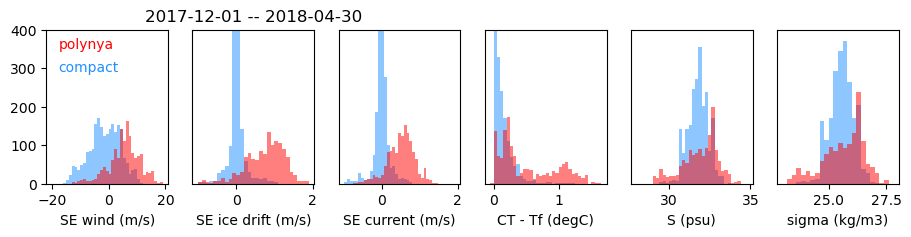

In [410]:
%matplotlib inline

fig, axs = plt.subplots(1,6, figsize=(11,2))

ax = axs[0]
ax.set_xlabel('SE wind (m/s)')
ax.set_ylim(0,400)
for event, color in zip([clos_times,open_times ], ['dodgerblue', 'r']):
    ax.hist(ds4.se.sel(time = event), bins=np.arange(-20,20,1), color=color, alpha=0.5)

ax = axs[1]
ax.set_xlabel('SE ice drift (m/s)')
ax.set_ylim(0,400)
ax.set_yticks([])
for event, color in zip([clos_times,open_times ], ['dodgerblue', 'r']):
    ax.hist(ds3.se.sel(time = event), bins=np.arange(-1,2,0.1), color=color, alpha=0.5)
    
ax.set_title(f"{time_range.start.date()} -- {time_range.stop.date()}")
ax = axs[2]
ax.set_xlabel('SE current (m/s)')
ax.set_ylim(0,400)
ax.set_yticks([])
for event, color in zip([clos_times,open_times ], ['dodgerblue', 'r']):
    ax.hist(ds.se.mean(dim='depth').sel(time = event), bins=np.arange(-1,2,0.075), color=color, alpha=0.5) 
    
ax = axs[3]
ax.set_xlabel('CT - Tf (degC)')
ax.set_ylim(0,400)
ax.set_yticks([])
for event, color in zip([clos_times,open_times ], ['dodgerblue', 'r']):
    ax.hist(ds2.dT.sel(depth=-16).sel(time = event), bins=np.arange(-0.05,1.7,0.05), color=color, alpha=0.5)
    
ax = axs[4]
ax.set_xlabel('S (psu)')
ax.set_ylim(0,400)
ax.set_yticks([])
for event, color in zip([clos_times,open_times ], ['dodgerblue', 'r']):
    ax.hist(ds2.Sp.sel(depth=-16).sel(time = event), bins=np.arange(28,35,0.2), color=color, alpha=0.5)
    
ax = axs[5]
ax.set_xlabel('sigma (kg/m3)')
ax.set_ylim(0,400)
ax.set_yticks([])
for event, color in zip([clos_times,open_times ], ['dodgerblue', 'r']):
    ax.hist(ds2.sig0.sel(depth=-16).sel(time = event), bins=np.arange(23,28,0.2), color=color, alpha=0.5)
    
ax = axs[0]
ax.text(0.1,0.95,'polynya', c='red', ha='left', va='top',transform=ax.transAxes)
ax = axs[0]
ax.text(0.1,0.8,'compact', c='dodgerblue', ha='left', va='top',transform=ax.transAxes)
    
fig.savefig('/Users/mackenziejewell/Desktop/img.png', dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


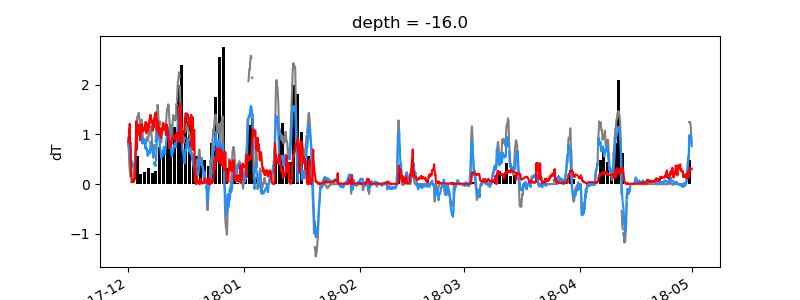

<BarContainer object of 151 artists>

In [334]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,3))
# plt.plot(ds3.time, exp_ice_se, c='lightgray')
# plt.plot(ds.time, exp_ice_se, c='k')
(ds3.se).plot(c='gray')

(ds.se.sel(depth=-10)).plot(c='dodgerblue')

(ds2.dT.sel(depth=-16)).plot(c='r')


plt.bar(DS.time, DS.extent/2000, align='edge', color='k')

# plt.bar(DS.time, (DS.l_max - DS.l_min)/50, align='edge', color='k')



# (ds.u.sel(depth=-22)).plot()

# ds2.dT.sel(depth=-16).plot()
# plt.ylim(-0.2,0.2)
# ds32.u.plot()

<xarray.DataArray 'depth' (depth: 4)>
array([-39., -28., -22., -16.])
Coordinates:
  * depth    (depth) float64 -39.0 -28.0 -22.0 -16.0


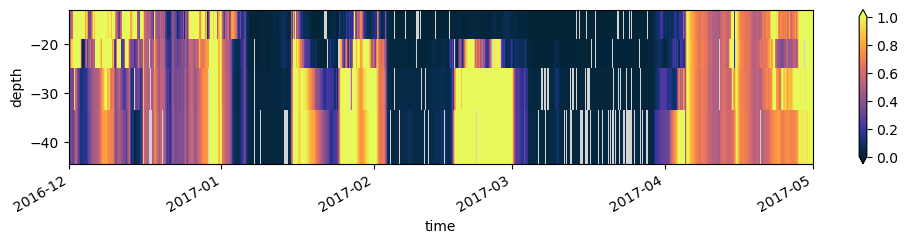

In [279]:
fig, ax = plt.subplots(figsize=(12,2))
ax.patch.set_facecolor('lightgray')


(ds2.Ct-ds2.Tf).plot(vmin=0, vmax=1, cmap=cmocean.cm.thermal)

# .sel(depth = np.array([-36,-28,-16]))
# ds2.Sp.plot(vmin=30, vmax=34, cmap=cmocean.cm.thermal)

print(ds2.depth)


# ax.plot(ds3.time, 8*(-ds3.u)-16,c='r',  clip_on = True)
# ax.plot(ds.time, 8*(-ds.u.mean(dim='depth'))-16,c='mediumpurple',  clip_on = True)

# ax.set_xlim(datetime(2017,2,15), datetime(2017,3,5))

### Evaluate data gaps

In [1516]:
#===================
retain_frac = 0.95
#===================

print(f'Ocean currents:')
for depth in ds.depth.values[::-1]:
    # finite fraction
    ffrac = np.sum(np.isfinite(ds.u.sel(depth=depth).values)) / len(ds.time)
    print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')

print(f'\nOcean temperatures:')
for depth in ds2.depth.values[::-1]:
    # finite fraction
    ffrac = np.sum(np.isfinite(ds2.Ct.sel(depth=depth).values)) / len(ds2.time)
    print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')
    
print(f'\nSea ice velocity:')
# finite fraction
ffrac = np.sum(np.isfinite(ds3.u.values)) / len(ds3.time)
print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')

Ocean currents:
z = -4.0 [0.51] 
z = -6.0 [0.76] 
z = -8.0 [0.91] 
z = -10.0 [0.97] *
z = -12.0 [0.98] *
z = -14.0 [0.97] *
z = -18.0 [0.93] 
z = -22.0 [0.87] 
z = -24.0 [0.90] 
z = -30.0 [1.00] *

Ocean temperatures:
z = -16.0 [1.00] *
z = -22.0 [1.00] *
z = -28.0 [1.00] *
z = -36.0 [1.00] *

Sea ice velocity:
z = -36.0 [1.00] *


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_52503/1511898339.py:9: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_52503/1511898339.py:15: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_52503/1511898339.py:20: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')


<IPython.core.display.Javascript object>


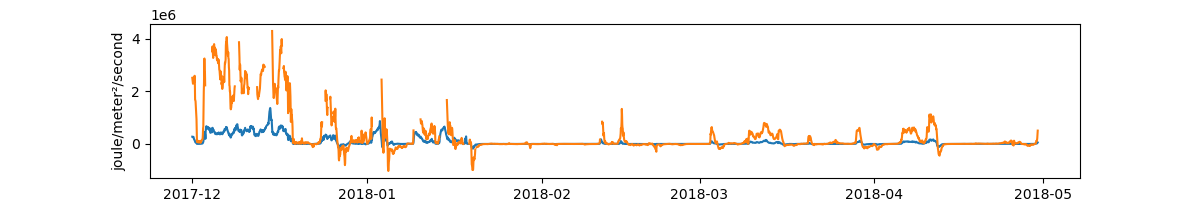

layer 0 [0, -16], dz = 16 meter
       interp U(-16) from: [-14.0 -18.0]


In [1517]:
def interp_U(ds, z_loc):
                
    ffrac = np.isfinite(ds.u).sum(dim='time') / len(ds.time)
    
    thresh = 0.9
    
    # find nearest velocity above / below:
    z_abv = ds.depth.values[(ds.depth.values > z_loc)&(ffrac.values>thresh)][0]
    z_blw = ds.depth.values[(ds.depth.values < z_loc)&(ffrac.values>thresh)][-1]
    print(f'       interp U({z_loc}) from: [{z_abv} {z_blw}]')

    U_abv = ds.se.sel(depth = z_abv).values
    U_blw = ds.se.sel(depth = z_blw).values

    # interp
    dz = z_loc-z_blw
    dZ = z_abv-z_blw
    dU = U_abv-U_blw
    U_interp = U_blw + dz*(dU/dZ)

    return U_interp
            
            
depths = [0, -16]#, -22, -28]

fig, ax = plt.subplots(figsize=(12,2))

OHT = np.array([])

for ii in range(len(depths[:-1])):
    
    z = {}
    Up = {}
    dT = {}
    
    z['a'] = depths[ii]
    z['b'] = depths[ii+1]
    
    dz = np.abs(z['a'] - z['b']) * units('m')
    
    print(f"layer {ii} [{z['a']}, {z['b']}], dz = {dz}")
    
    if z['a']==0:
#         dT['a'] = (0 + np.zeros(len(ds2.time))) * units('delta_degC')
        Up['a'] = ds3.se.values * units('m/s')
        dT['a'] = 0.1 * (ds2.Ct - ds2.Tf).sel(depth=z['b']).values * units('delta_degC')
        
    else:
        dT['a'] = (ds2.Ct - ds2.Tf).sel(depth=z['a']).values * units('delta_degC')
        Up['a'] = interp_U(ds, z['a']) * units('m/s')
        
        
    dT['b'] = (ds2.Ct - ds2.Tf).sel(depth=z['b']).values * units('delta_degC')
    Up['b'] = interp_U(ds, z['b']) * units('m/s')
    
    
    a_OHT = cst['Cp_o'] * cst['rho_o'] * dT['a'] * Up['a']
    b_OHT = cst['Cp_o'] * cst['rho_o'] * dT['b'] * Up['b']
    
    # add in the time component (hourly velocity measurements, so mass flux integrated over an hour)
#     a_OHT = a_OHT * units('hour').to('s')
#     b_OHT = b_OHT * units('hour').to('s')
    
    trap_OHT = 0.5 * (a_OHT + b_OHT) * dz
    
    ax.plot(ds2.time, a_OHT)
    ax.plot(ds2.time, b_OHT)

    

In [1220]:
# trap_OHT1 = trap_OHT

<IPython.core.display.Javascript object>


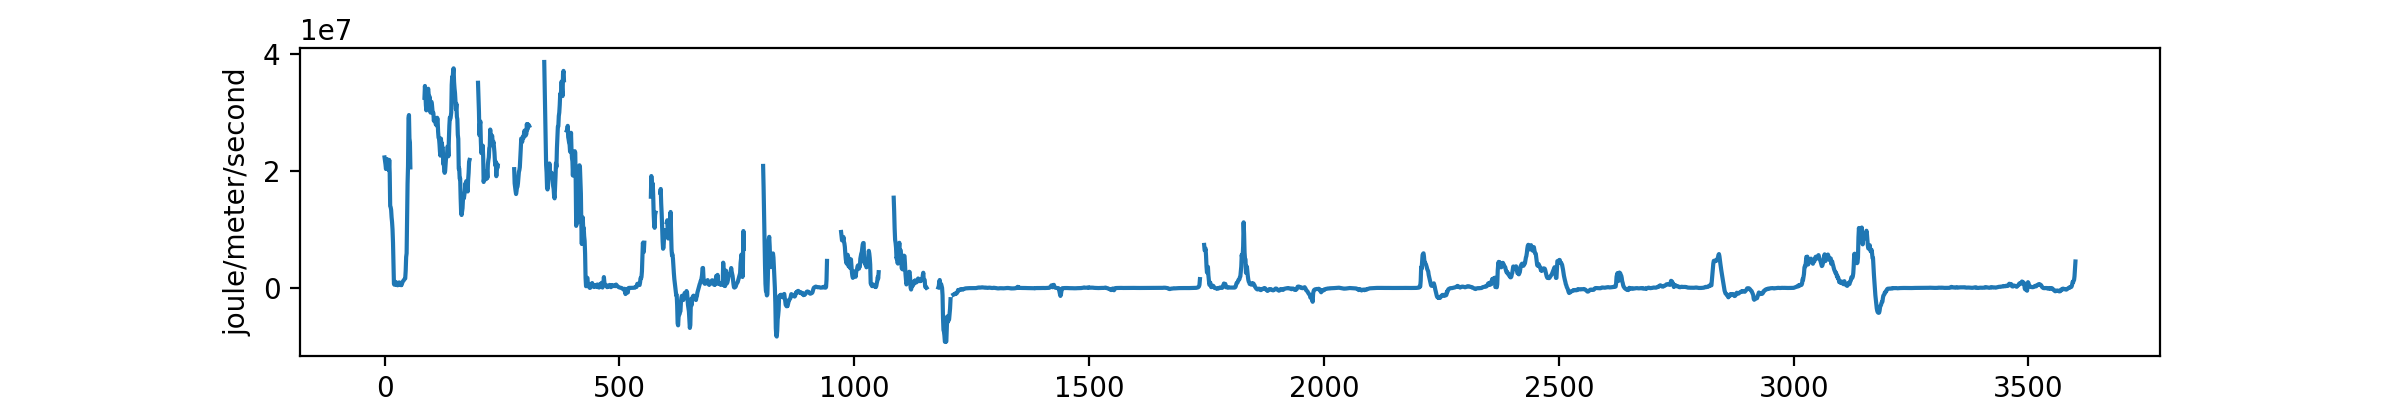

In [1351]:
fig, ax = plt.subplots(figsize=(12,2))

plt.plot(trap_OHT)


<IPython.core.display.Javascript object>


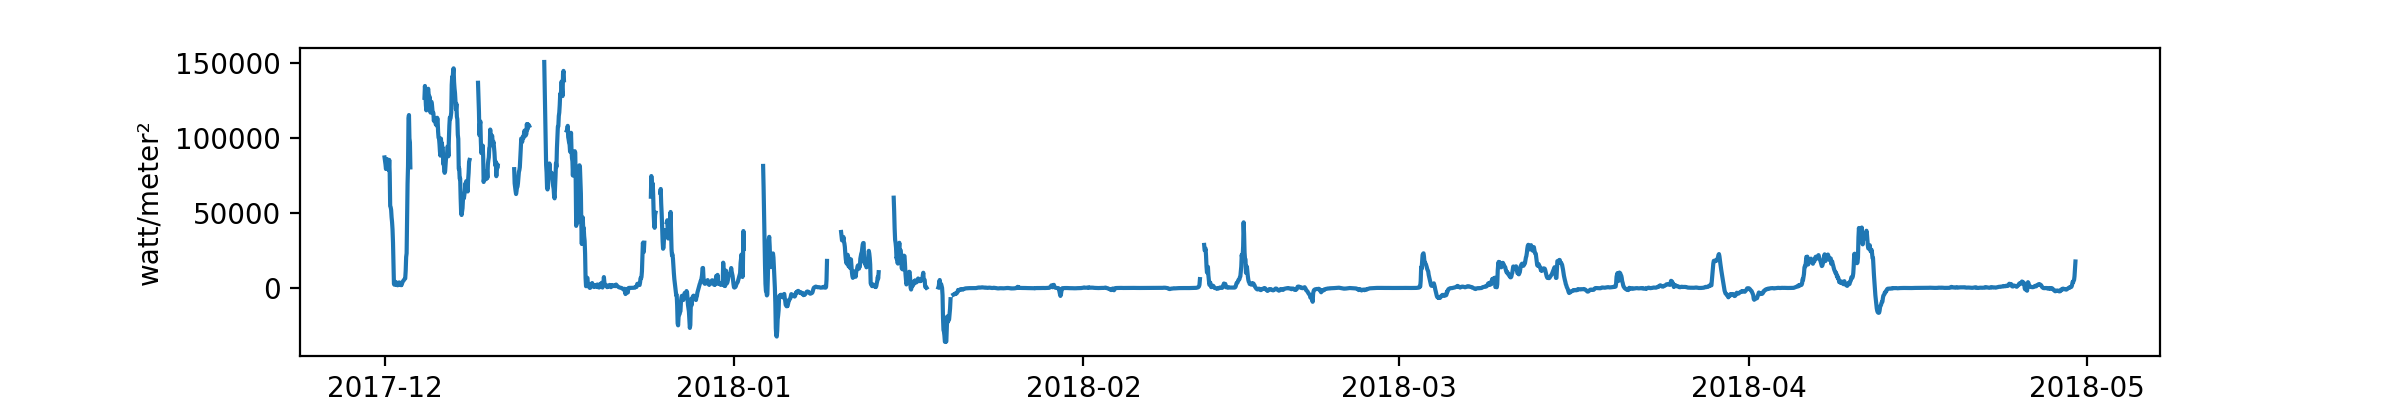

ValueError: x and y must have same first dimension, but have shapes (3601,) and (2905,)

In [1352]:
fig, ax = plt.subplots(figsize=(12,2))


F1 = (trap_OHT/dz).to('W/m2') /16
F2 = 100*0.5*THF.to('W/m2')


ax.plot(ds.time, F1)
ax.plot(ds.time, F2)

# lag = 6
# dOHC = (OHC.magnitude[0,:][2*lag:] - OHC.magnitude[0,:][:-2*lag])/(24*60*60)
# plt.plot(ds.time[lag:-lag], dOHC, label = 'surface')
plt.legend()

## Calculate Integrate Ocean Heat Content

Use trapezoidal rule to estimate integrate ocean heat content
OHC = $\sum{\frac{1}{2} [f(x_i) + f(x_{i+1})}] \Delta x$

$\mathrm{f(z) = C_{p} \;\rho_{o}(z)\; (\Theta(z) - \Theta_{freezing}(z))}$

In [1353]:
OHC = np.array([])

Z = np.append(np.array([0]), ds2.depth.values[::-1])

for ii in range(len(Z[:-1])):
    
    print(ii)
    
    za = Z[ii] * units('m')
    zb = Z[ii+1] * units('m')
    
    dz = za - zb
    
    print(f'za = {za}; zb = {zb}; dz = {dz}')
    
    # define upper
    if ii == 0:
        rho_a = (ds2.sel(depth = zb).sig0 + 1000).values * units('kg/m^3')
        dCTa = np.zeros(len(ds2.Ct.sel(depth = zb))) * units('delta_degC')

    else:
        rho_a = (ds2.sel(depth = za).sig0 + 1000).values * units('kg/m^3')
        dCTa = (ds2.Ct - ds2.Tf).sel(depth = za).values * units('delta_degC')
        
    # grab lower
    rho_b = (ds2.sel(depth = zb).sig0 + 1000).values * units('kg/m^3')
    dCTb = (ds2.Ct - ds2.Tf).sel(depth = zb).values * units('delta_degC')
    
    layer_hc = 0.5 * dz

    f_za = cst['Cp_o'] * rho_a * dCTa
    f_zb = cst['Cp_o'] * rho_b * dCTb
    
    OHC = np.append(OHC, 0.5 * (f_za + f_zb) * dz)
    
    
OHC = np.reshape(OHC, (len(Z[:-1]), len(ds2.time), ))

0
za = 0.0 meter; zb = -16.0 meter; dz = 16.0 meter
1
za = -16.0 meter; zb = -22.0 meter; dz = 6.0 meter
2
za = -22.0 meter; zb = -28.0 meter; dz = 6.0 meter
3
za = -28.0 meter; zb = -36.0 meter; dz = 8.0 meter


## Calculate Integrated Ocean Heat Transport

Use trapezoidal rule to estimate integrate ocean heat content
OHC = $\sum{\frac{1}{2} [f(x_i) + f(x_{i+1})}] \Delta x$

$\mathrm{f(z) = C_{p} \;\rho_{o}(z)\; U_{\perp}(z)\; (\Theta(z) - \Theta_{freezing}(z))}$

In [1354]:
OHC = np.array([])

Z = np.append(np.array([0]), ds2.depth.values[::-1])

for ii in range(len(Z[:-1])):
    
    print(ii)
    
    za = Z[ii] * units('m')
    zb = Z[ii+1] * units('m')
    
    dz = za - zb
    
    print(f'za = {za}; zb = {zb}; dz = {dz}')
    
    # define upper
    if ii == 0:
        rho_a = (ds2.sel(depth = zb).sig0 + 1000).values * units('kg/m^3')
        dCTa = np.zeros(len(ds2.Ct.sel(depth = zb))) * units('delta_degC')

    else:
        rho_a = (ds2.sel(depth = za).sig0 + 1000).values * units('kg/m^3')
        dCTa = (ds2.Ct - ds2.Tf).sel(depth = za).values * units('delta_degC')
        
    # grab lower
    rho_b = (ds2.sel(depth = zb).sig0 + 1000).values * units('kg/m^3')
    dCTb = (ds2.Ct - ds2.Tf).sel(depth = zb).values * units('delta_degC')
    
    layer_hc = 0.5 * dz

    f_za = cst['Cp_o'] * rho_a * dCTa
    f_zb = cst['Cp_o'] * rho_b * dCTb
    
    OHC = np.append(OHC, 0.5 * (f_za + f_zb) * dz)
    
    
OHC = np.reshape(OHC, (len(Z[:-1]), len(ds2.time), ))

0
za = 0.0 meter; zb = -16.0 meter; dz = 16.0 meter
1
za = -16.0 meter; zb = -22.0 meter; dz = 6.0 meter
2
za = -22.0 meter; zb = -28.0 meter; dz = 6.0 meter
3
za = -28.0 meter; zb = -36.0 meter; dz = 8.0 meter


In [1355]:
# times = pd.to_datetime(ds2.time.values)
# times = np.append(times, times[-1] + timedelta(hours=1))

times = pd.to_datetime(ds2.time.values).to_pydatetime()
times = np.append(times, times[-1] + timedelta(hours=1))

time_grid, Zgrid = np.meshgrid(times, Z)#[:-1]+np.diff(Z)/2)

<IPython.core.display.Javascript object>


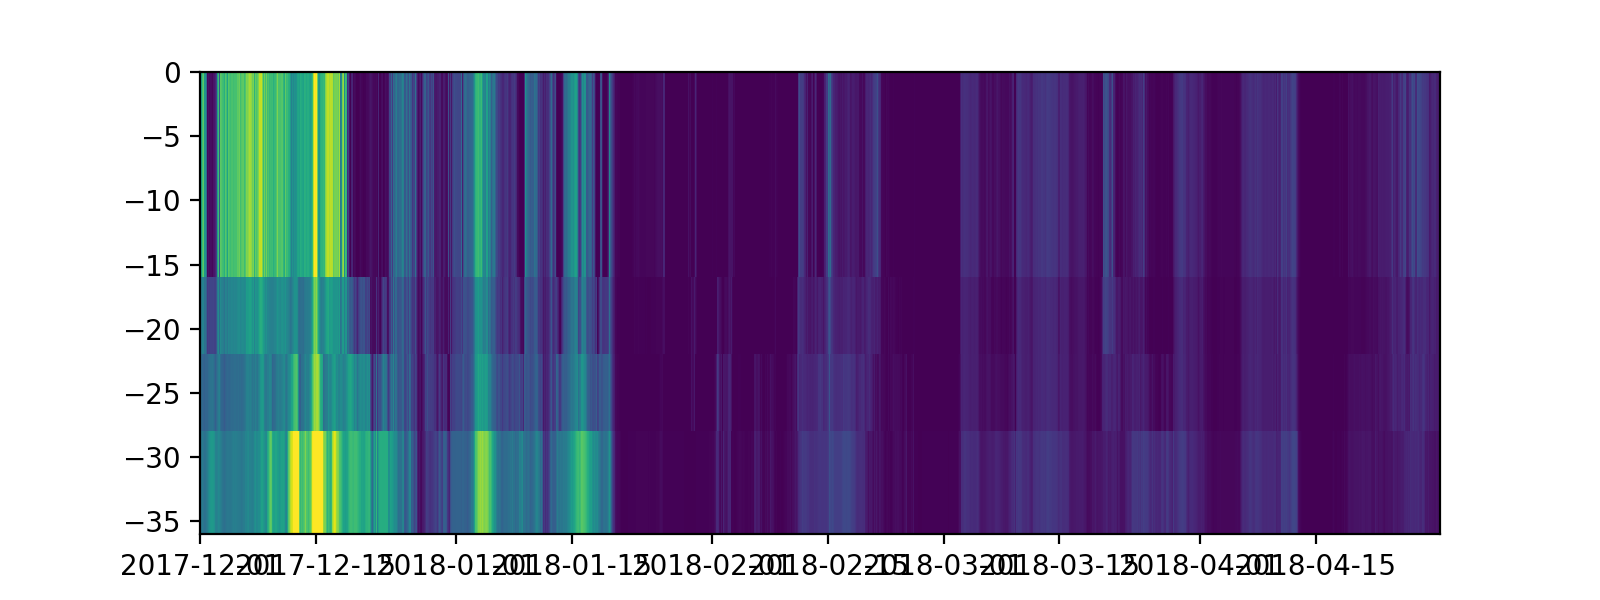

In [1356]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh(time_grid, Zgrid, OHC, vmin=500000, vmax = 50000000)

<IPython.core.display.Javascript object>


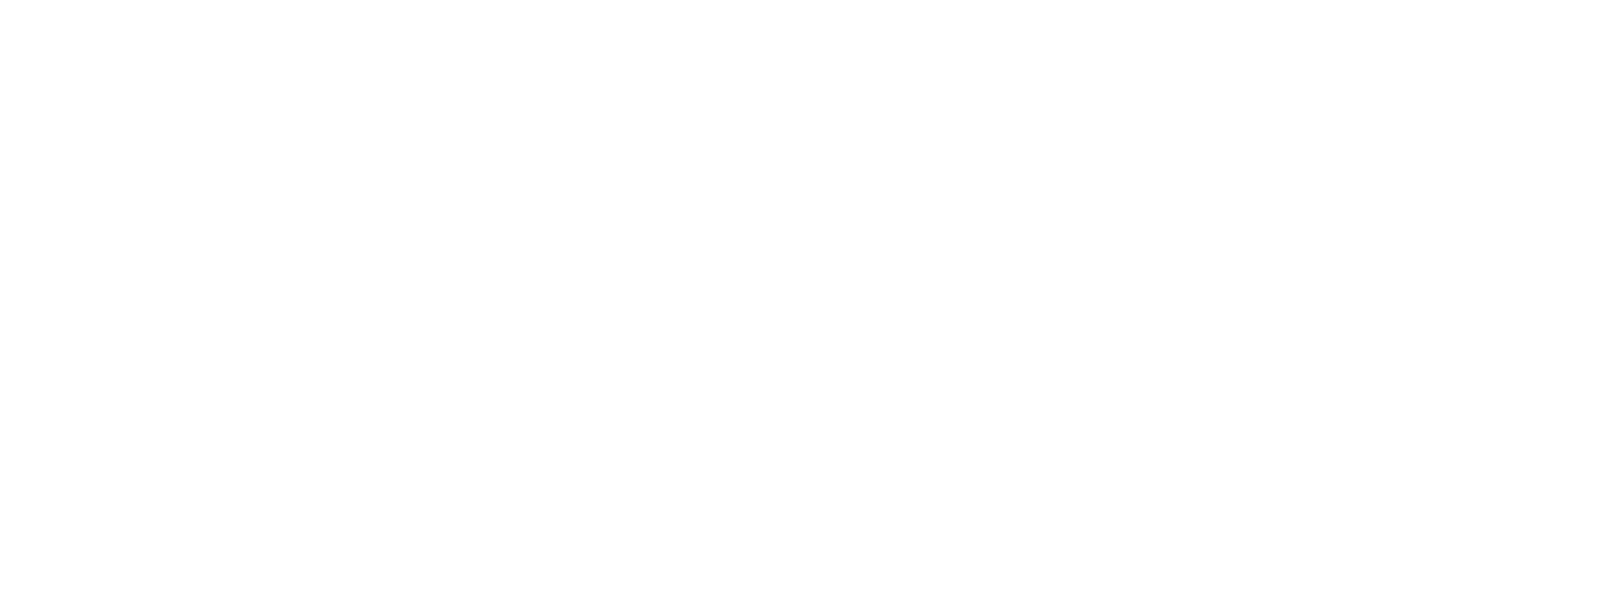

<IPython.core.display.Javascript object>


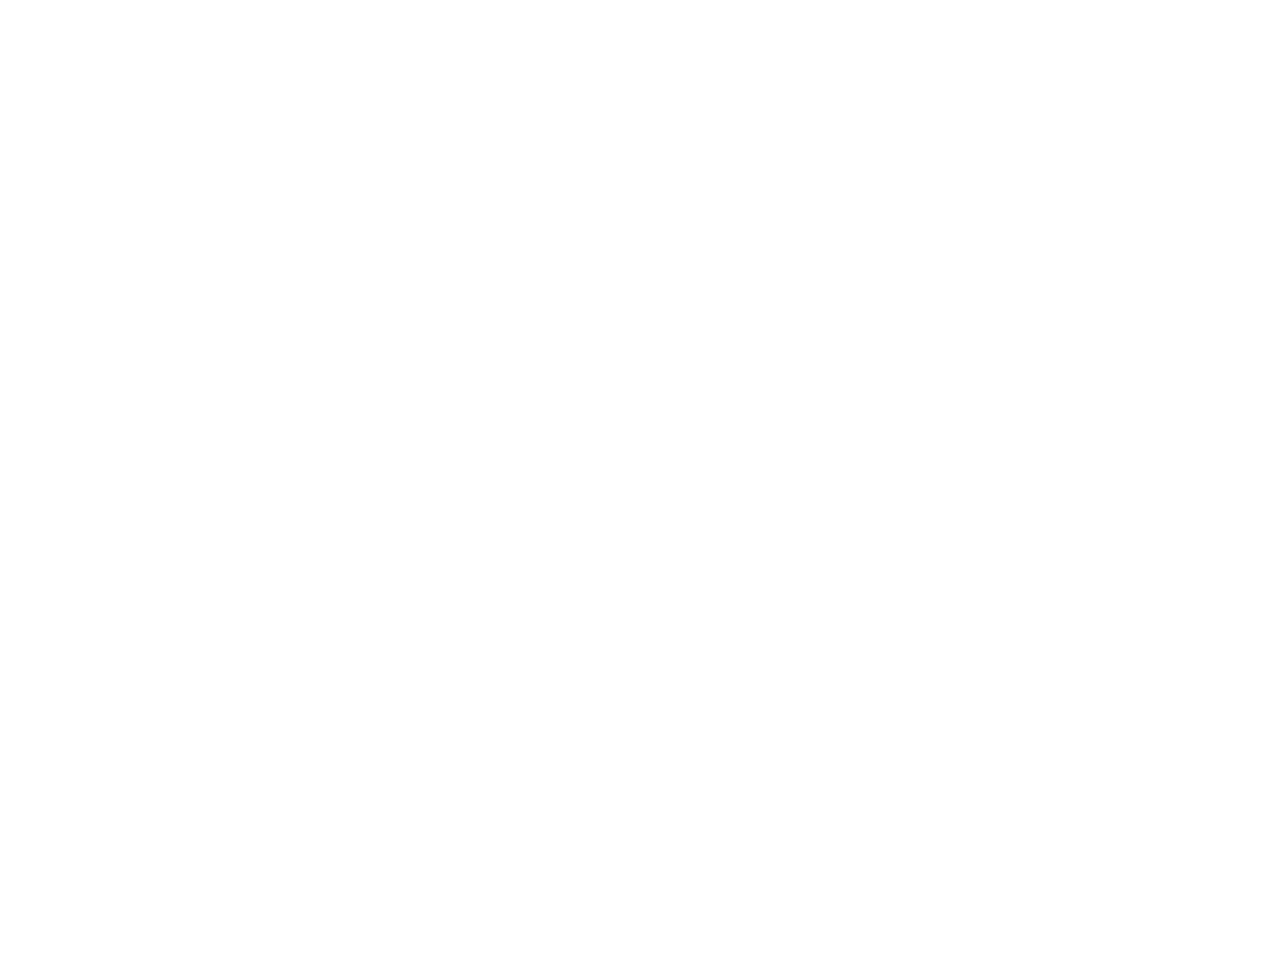

<IPython.core.display.Javascript object>


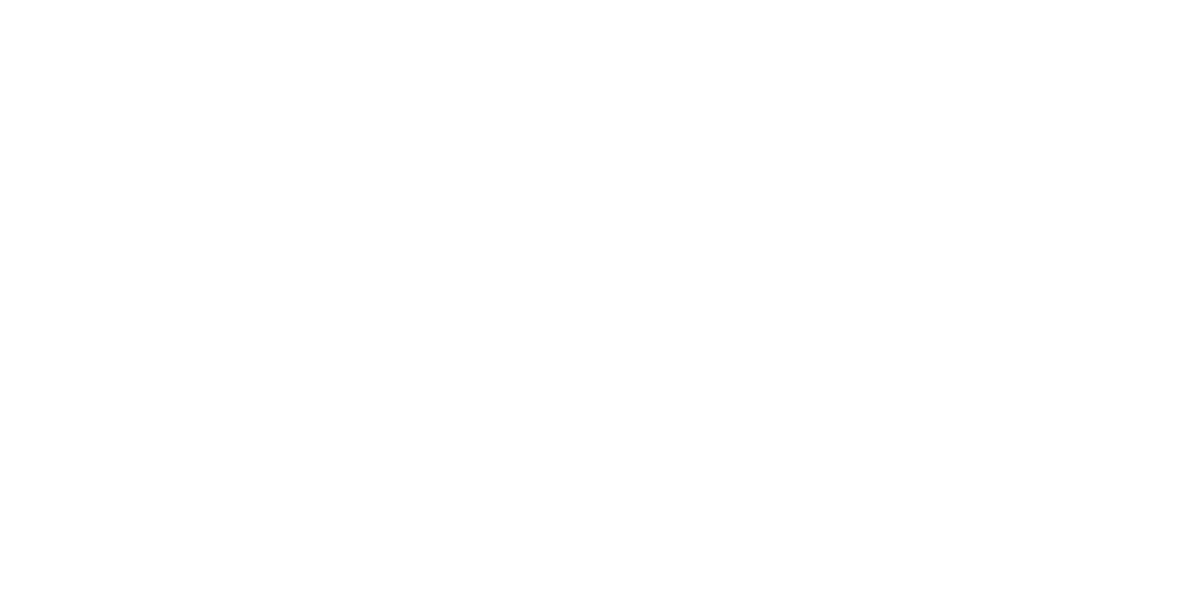

<IPython.core.display.Javascript object>


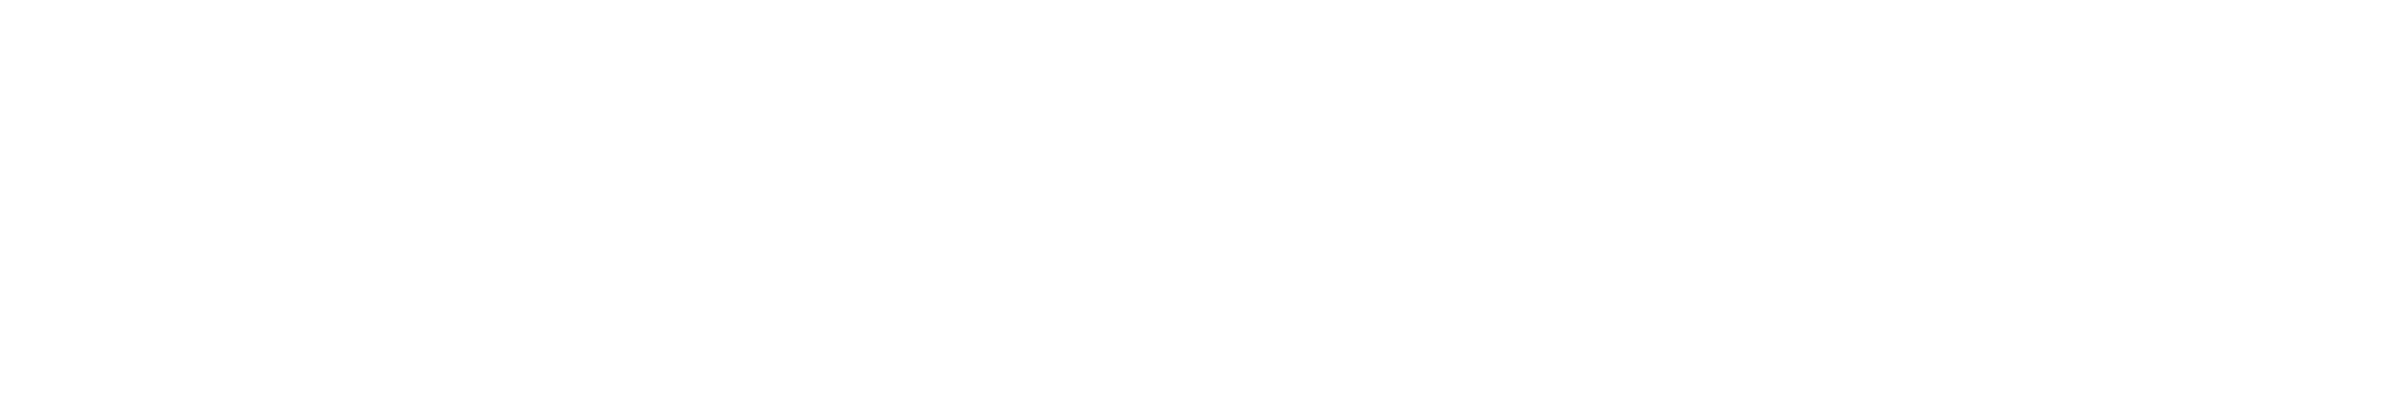

<IPython.core.display.Javascript object>


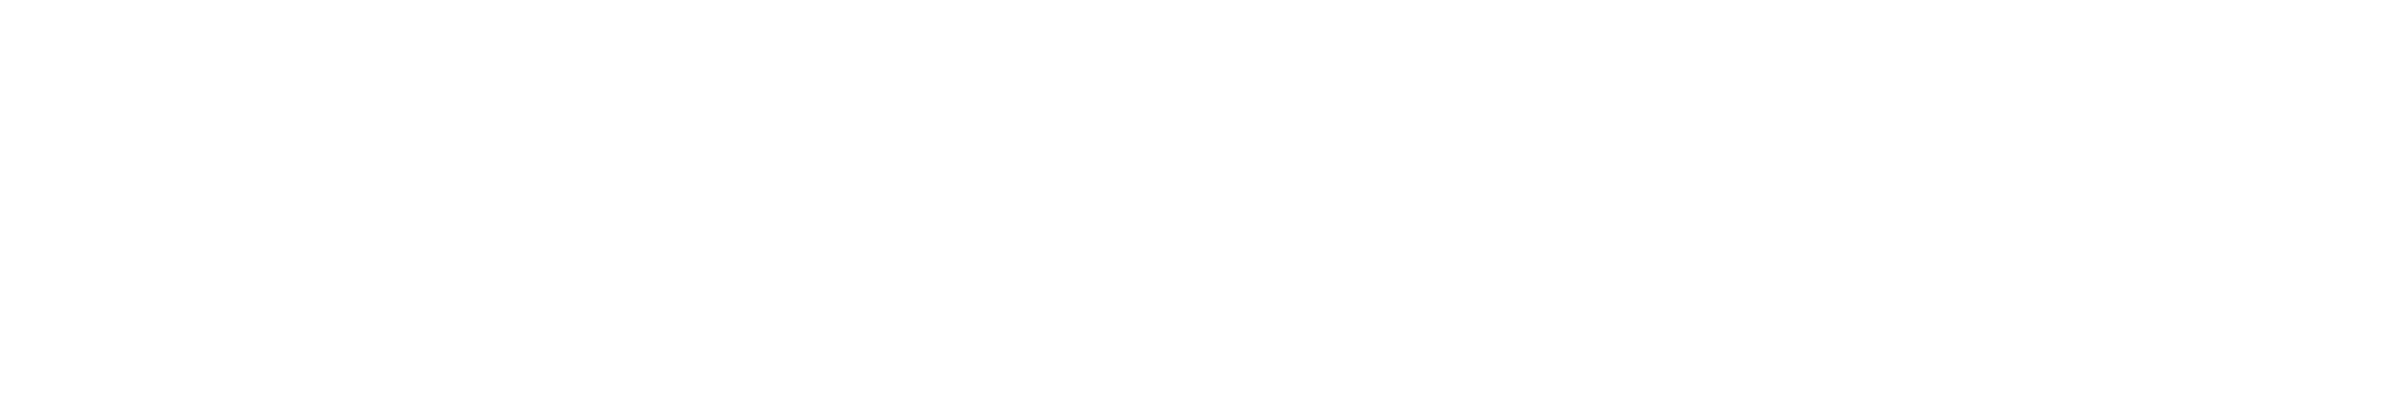

<IPython.core.display.Javascript object>


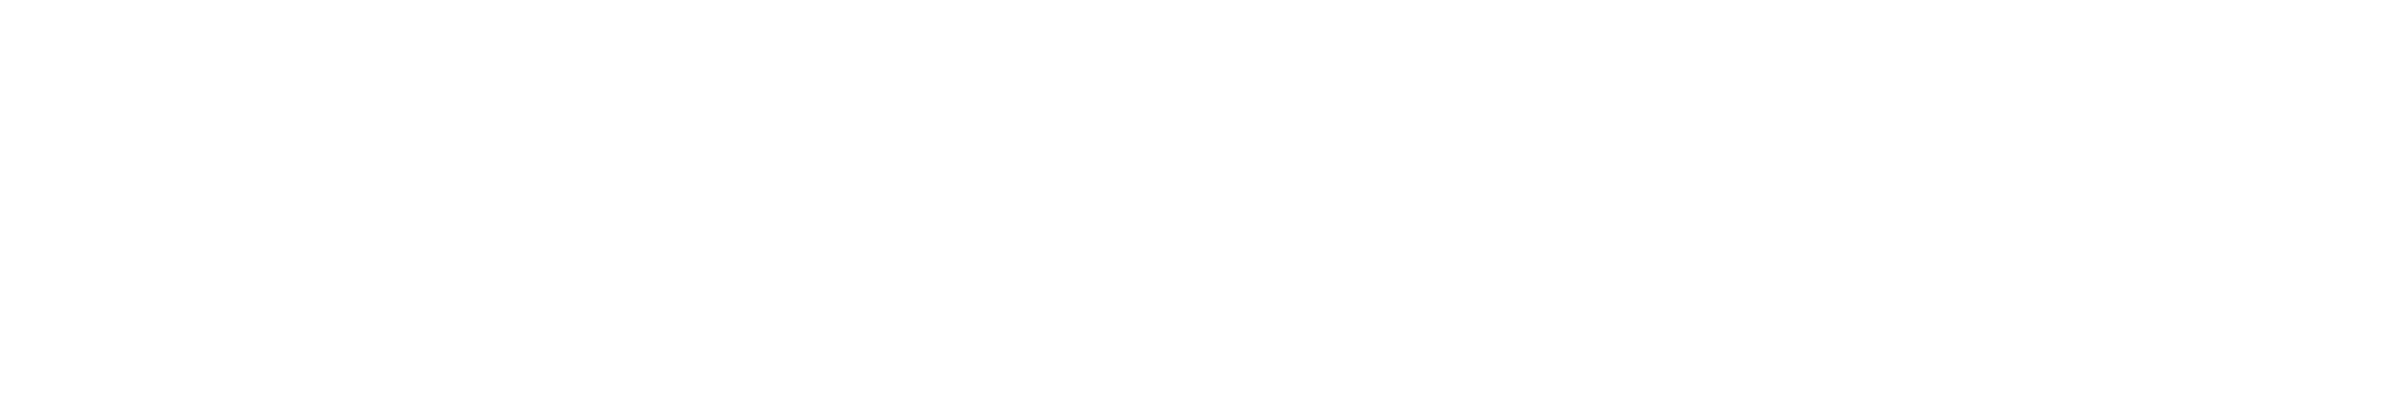

<IPython.core.display.Javascript object>


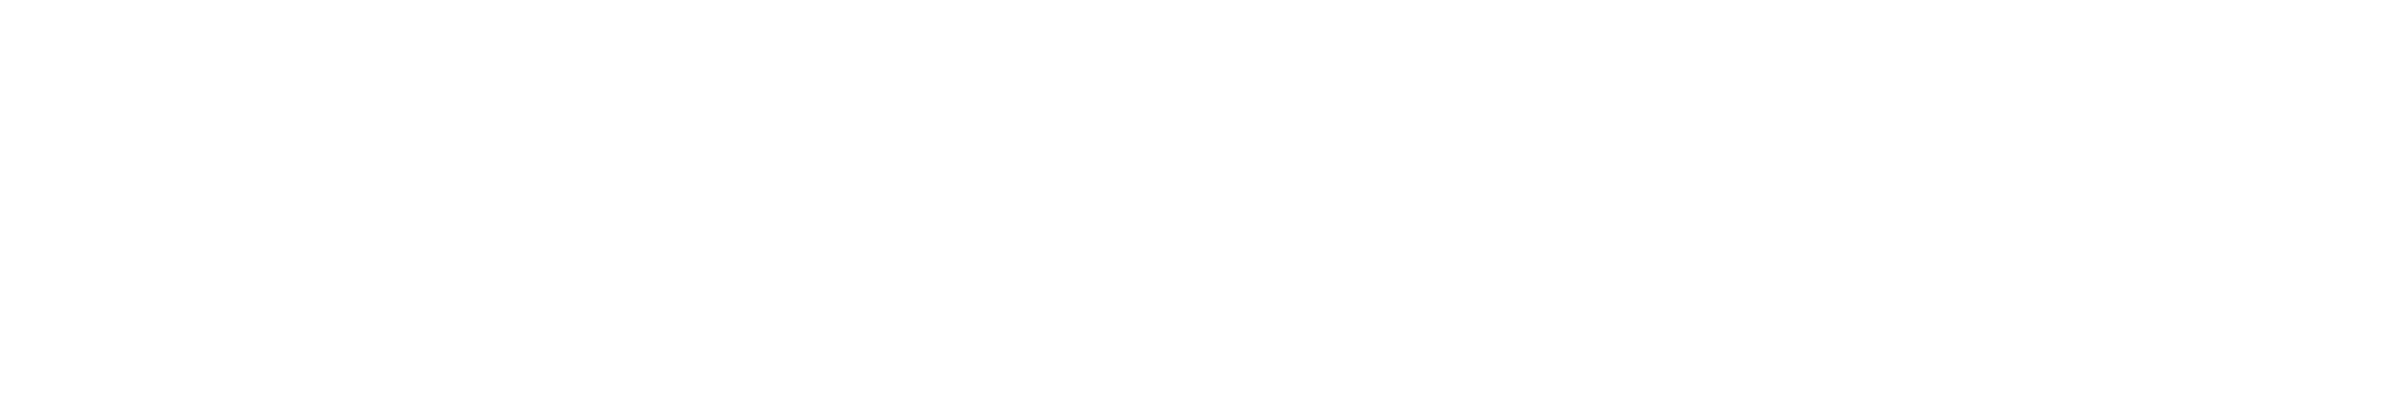

<IPython.core.display.Javascript object>


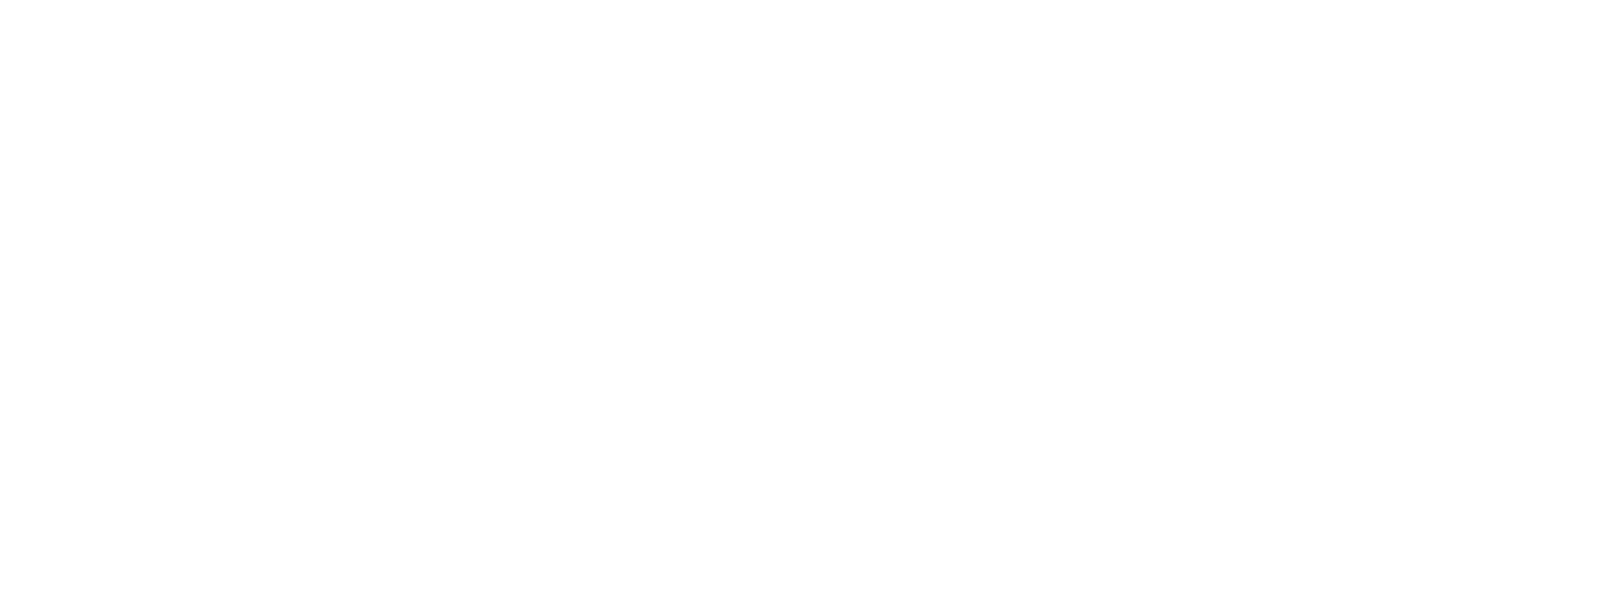

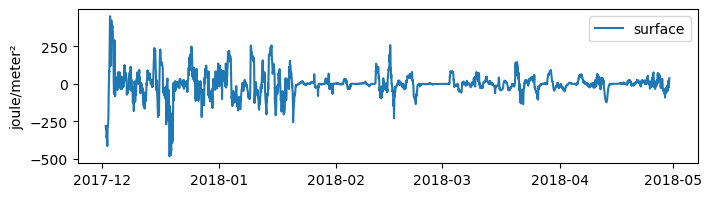

In [1357]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8,2))
# ax.set_ylim(-5000000,150000000)
# plt.plot(ds2.time, np.sum(OHC, axis=0), label = 'total')
# plt.plot(ds2.time, OHC[0,:], label = 'surface')

lag = 24

plt.plot(ds2.time[lag:], (OHC[0,:][lag:] - OHC[0,:][:-lag])/(24*60*60), label = 'surface')
plt.legend()

# ax.set_xlim(datetime(2017,12,1), datetime(2018,2,1))

<IPython.core.display.Javascript object>


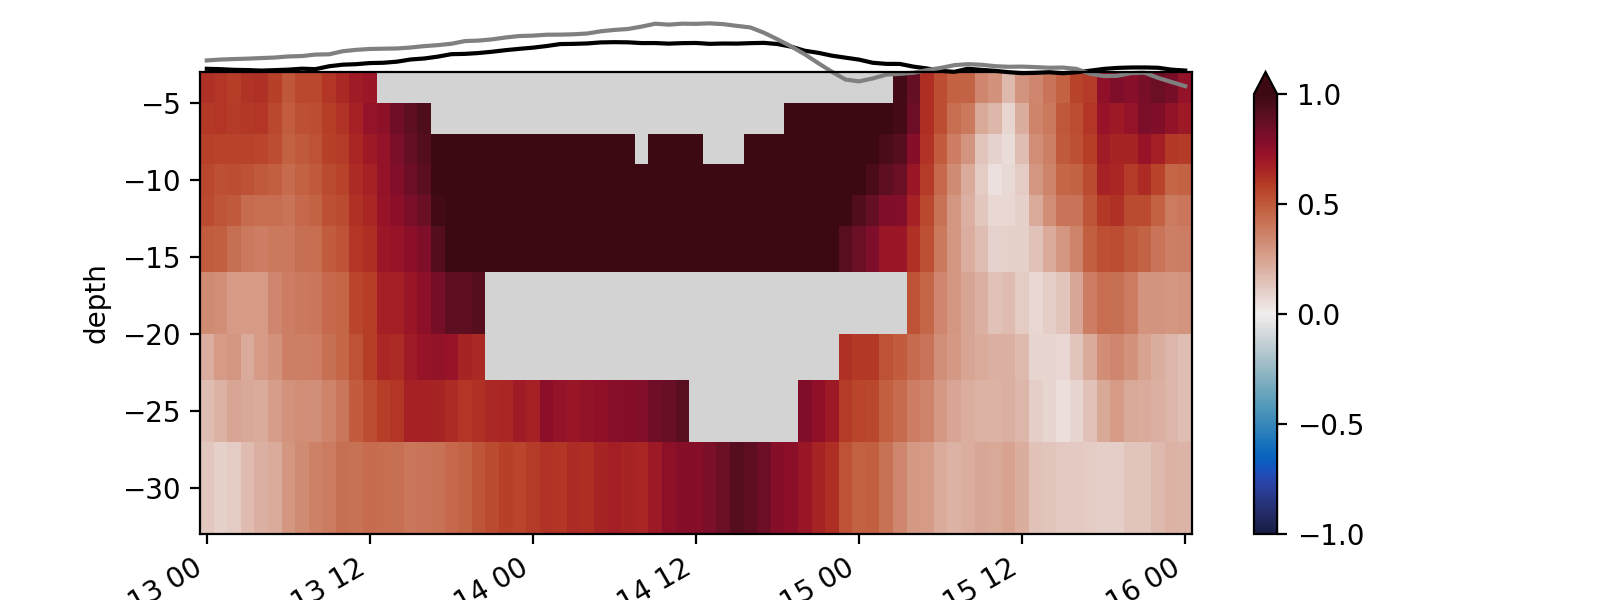

In [1366]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8,3))
ax.patch.set_facecolor('lightgray')

# event_time = slice(datetime(2016,12,15), datetime(2016,12,17, 12))

event_time = slice(datetime(2018,1,13,0), datetime(2018,1,16, ))

# event_time = slice(datetime(2017,1,14), datetime(2017,1,15, 18))

# event_time = slice(datetime(2018,1,4,12), datetime(2018,1,9))

# event_time = slice(datetime(2018,1,1,0), datetime(2018,1,17))

# event_time = slice(datetime(2018,1,8,12), datetime(2018,1,11))


along_sfc.sel(time=event_time).plot(vmin=-1, vmax=1, cmap=cmocean.cm.balance)

ax.plot(ds3.time.sel(time=event_time), ds3.se.sel(time=event_time)-3.5, c='k', clip_on=False)


ax.plot(ds3.time.sel(time=event_time), 0.2*ds4.se.sel(time=event_time)-3.5, c='gray', clip_on=False)


<IPython.core.display.Javascript object>


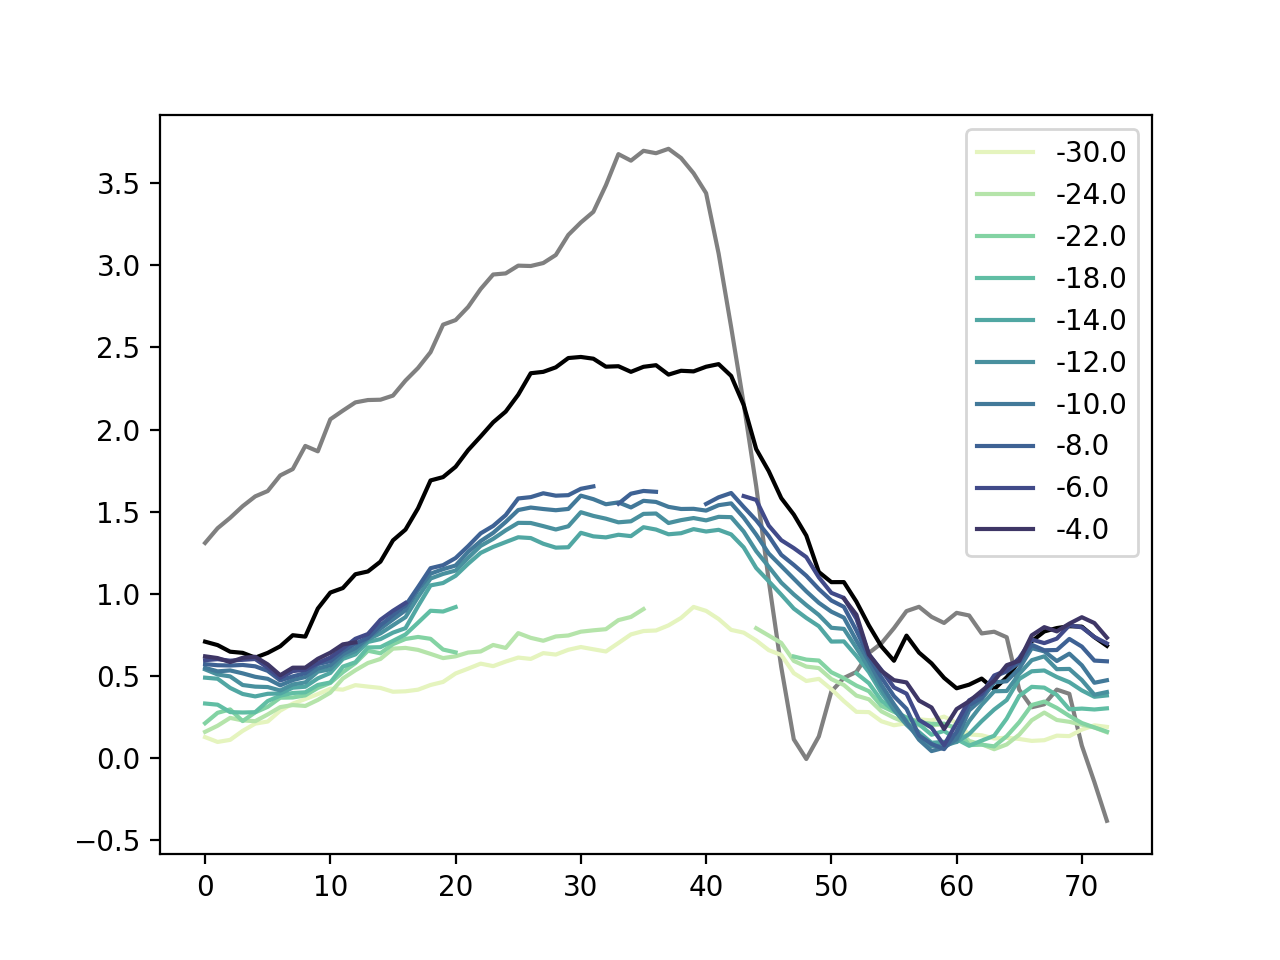

In [1368]:
fig, ax = plt.subplots()

plt.plot(0.2*wind_along_sfc.sel(time=event_time), c='gray')
plt.plot(icespeed.sel(time=event_time), c='k')

color_list = cmocean.cm.deep(np.linspace(0.05,0.85,len(ds.depth.values)))

for dd, depth in enumerate(ds.depth.values):
    
    color = color_list[dd]
    
    plt.plot(along_sfc.sel(depth = depth,time=event_time), c=color, label=depth)
    
plt.legend()

<IPython.core.display.Javascript object>


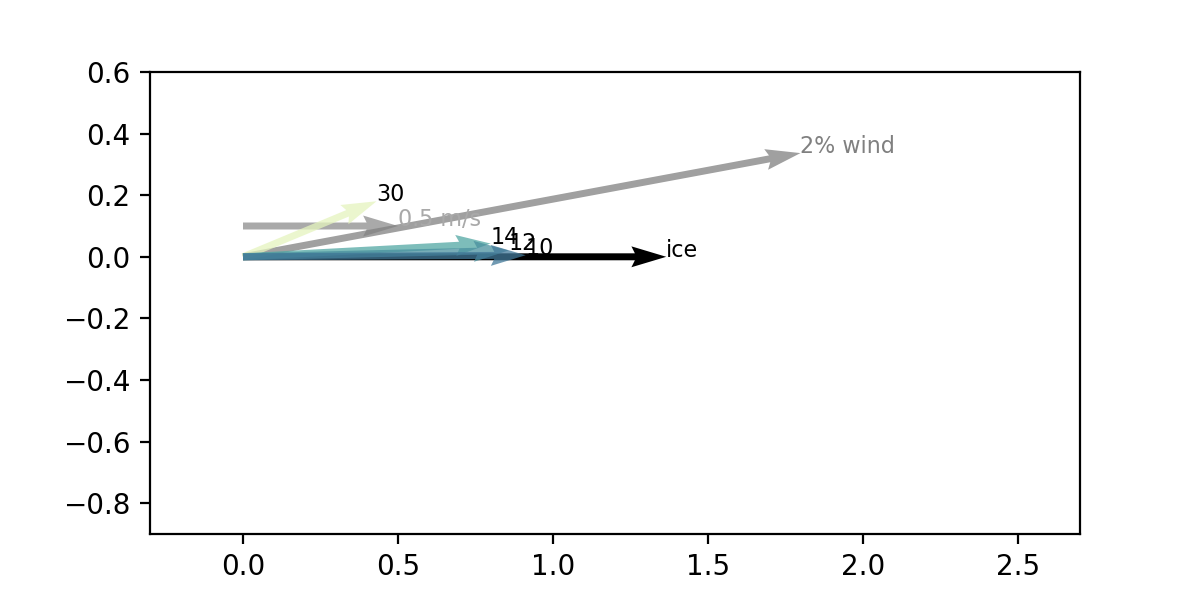

In [1369]:
fig, ax = plt.subplots(figsize=(6,3))

size = 3

ax.set_xlim(-0.1*size,0.9*size)
ax.set_ylim(-0.3*size,0.2*size)

textsize = 8

sfc_along_sfc_mean = (u_sfc.sel(time=event_time) * u_norm) + (v_sfc.sel(time=event_time) * v_norm)

plt.quiver(np.array([0]), np.array([0.1]),
           np.array([0.5]), np.array([0]), 
            color='darkgray', angles='xy', scale_units='xy', scale=1)
plt.text(np.array([0.5]), np.array([0.1]), '0.5 m/s', size=textsize, c='darkgray')

plt.quiver(np.nanmean(sfc_along_sfc_mean), np.array([0]), 
            color='k', angles='xy', scale_units='xy', scale=1)

# plt.quiver(u_sfc.sel(time=event_time).mean(dim='time'), v_sfc.sel(time=event_time).mean(dim='time'), 
#             color='k', angles='xy', scale_units='xy', scale=1)


UW = 0.2*wind_along_sfc.sel(time=event_time).mean(dim='time')
VW = 0.2*wind_perp_sfc.sel(time=event_time).mean(dim='time')
plt.quiver(UW, VW, color='gray', angles='xy', scale_units='xy', scale=1, alpha=0.75)
plt.text(UW, VW, '2% wind', size=textsize, c='gray')


plt.text(np.nanmean(sfc_along_sfc_mean), np.array([0]), 'ice', size=textsize)

for dd, depth in enumerate(ds.depth.values):
    
    color = color_list[dd]
    
    ffrac = np.sum(np.isfinite(along_sfc.sel(depth = depth, time=event_time))).values / len(ds.time.sel(time=event_time).values)
    
    if ffrac > 0.95:
    
        U = along_sfc.sel(depth = depth, time=event_time).mean(dim='time')
        V = perp_sfc.sel(depth = depth, time=event_time).mean(dim='time')
        
#         U = ds.u.sel(depth = depth, time=event_time).mean(dim='time')
#         V = ds.v.sel(depth = depth, time=event_time).mean(dim='time')

#         speed = np.sqrt(along_sfc.sel(depth = depth, time=event_time)**2 + perp_sfc.sel(depth = depth, time=event_time)**2)
        
        
        
        plt.quiver(U, V, color=color, angles='xy', scale_units='xy', scale=1, alpha=0.75)
        
        plt.text(U, V, f'{-depth:.0f}', size=textsize, c='k',)
        

In [1373]:
depth = -10

U = along_sfc.sel(depth = depth, time=event_time).mean(dim='time').values
V = perp_sfc.sel(depth = depth, time=event_time).mean(dim='time').values

a = np.array([U,V])
b = np.array([1,0])
c = np.dot(a,b)/np.linalg.norm(a)/np.linalg.norm(b) # -> cosine of the angle
angle = np.arccos(np.clip(c, -1, 1)) # if you really want the angle

ocean_speed = np.sqrt(ds.u**2+ds.v**2).sel(depth = depth, time=event_time)
speed_ratio = np.nanmean(ocean_speed)/np.nanmean(icespeed.sel(time=event_time))

print(f'angle: {angle * 180/np.pi : .1f}')
print(f'speed ratio: {speed_ratio : .3f}')

angle:  0.3
speed ratio:  0.678


In [1375]:
us0 = {}




def calc_CD(z, z0, kappa):
    
    # z is positive here
    sqrt_CD = ((1/kappa)*np.log(z/z0))**(-1)

    return sqrt_CD
    
    
z0_vals = [0.001, 0.05]
# z_vals = [-6,-8,-10,-30]

z_vals = [-10]

for z0 in z0_vals:
    
    us0[z0] = {}
    
    print(f'\nz0 = {z0}')

    for z in z_vals:

        
        sqrt_CD = calc_CD(-z, z0, cst['kappa'])
        print(f'   z = {z}, sqrt_CD = {sqrt_CD:.3f}')
        
        del_u = ds.u.sel(depth = z) - u_sfc
        del_v = ds.v.sel(depth = z) - v_sfc
        dU = np.sqrt(del_u**2 + del_v**2)

        us0_val = sqrt_CD * dU.values
        
        us0[z0][z] = us0_val


z0 = 0.001
   z = -10, sqrt_CD = 0.043 

z0 = 0.05
   z = -10, sqrt_CD = 0.075 


Text(0, 0.5, '$u_{*0}$')

<IPython.core.display.Javascript object>


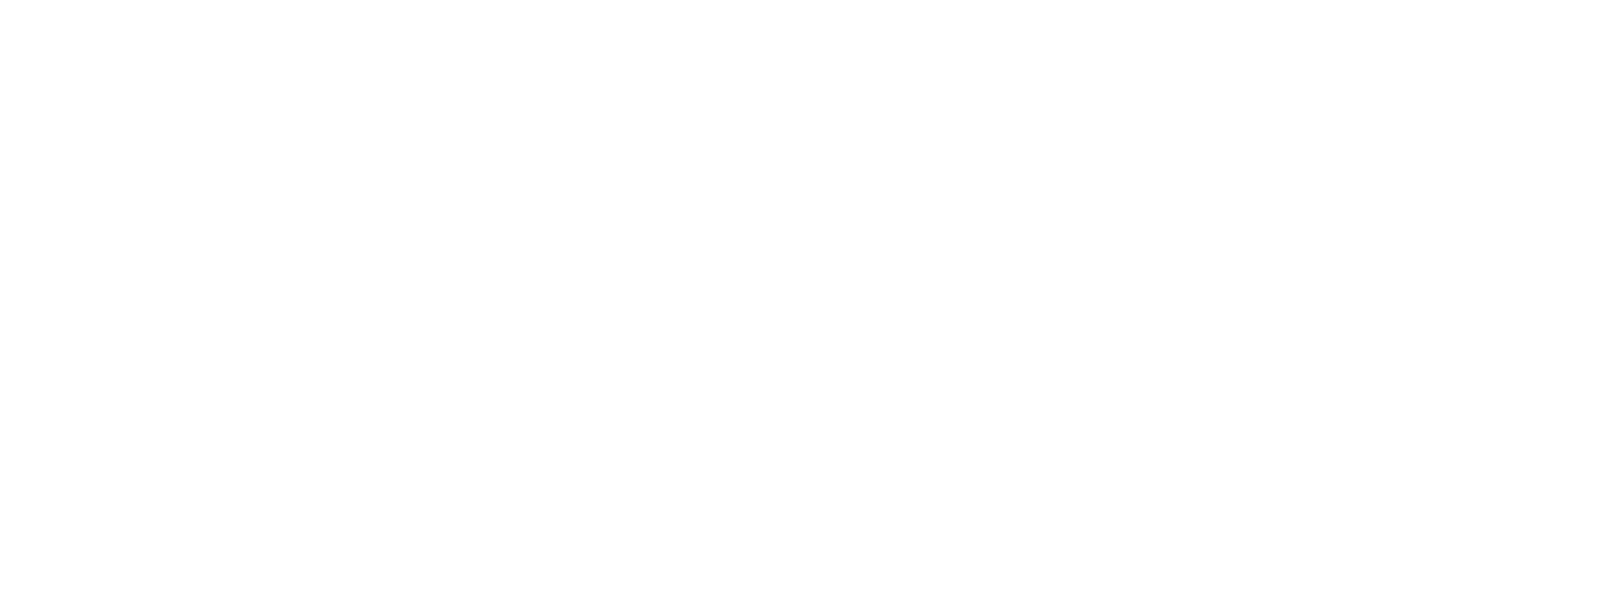

<IPython.core.display.Javascript object>


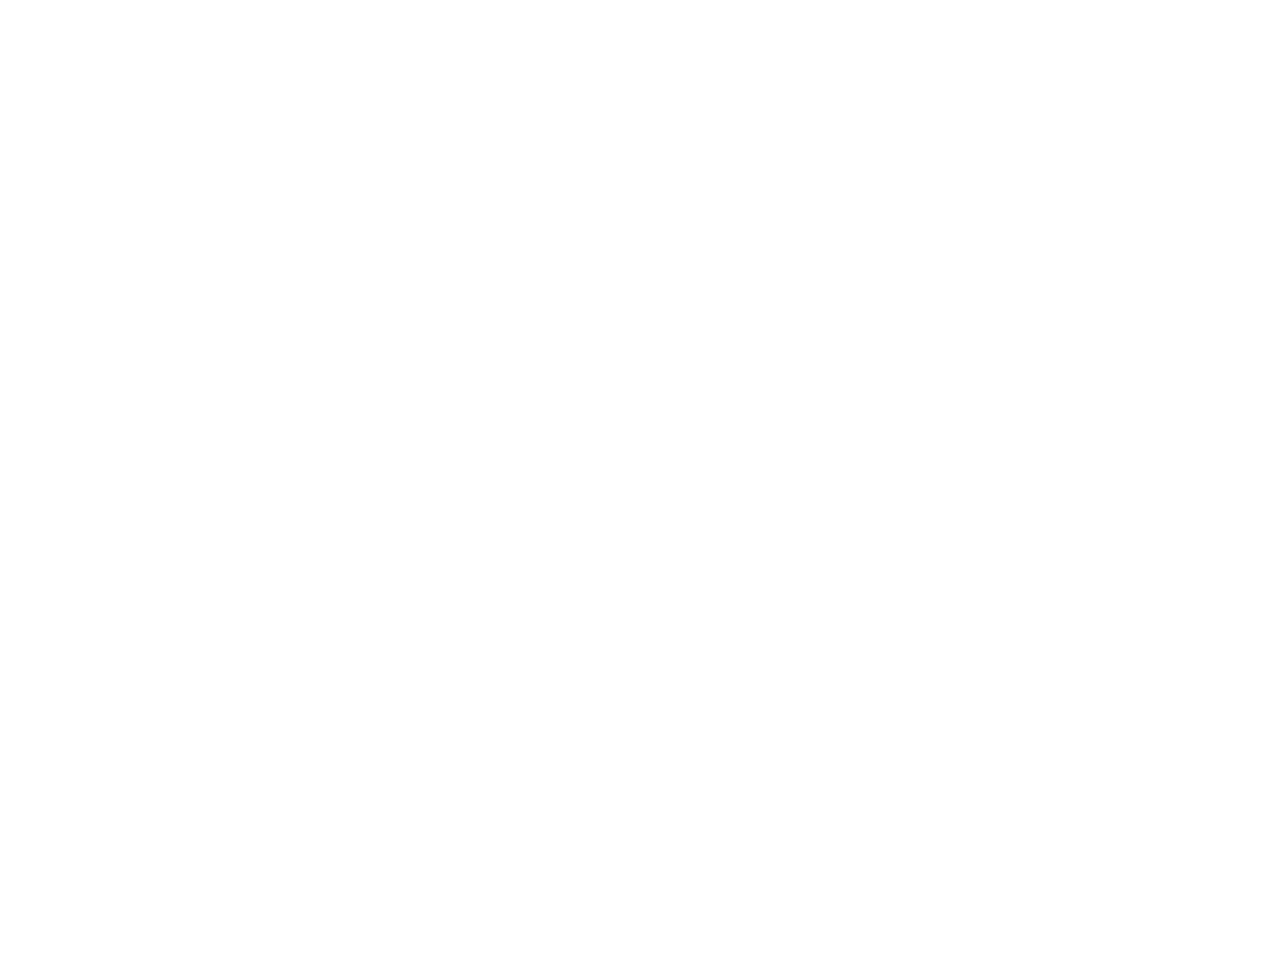

<IPython.core.display.Javascript object>


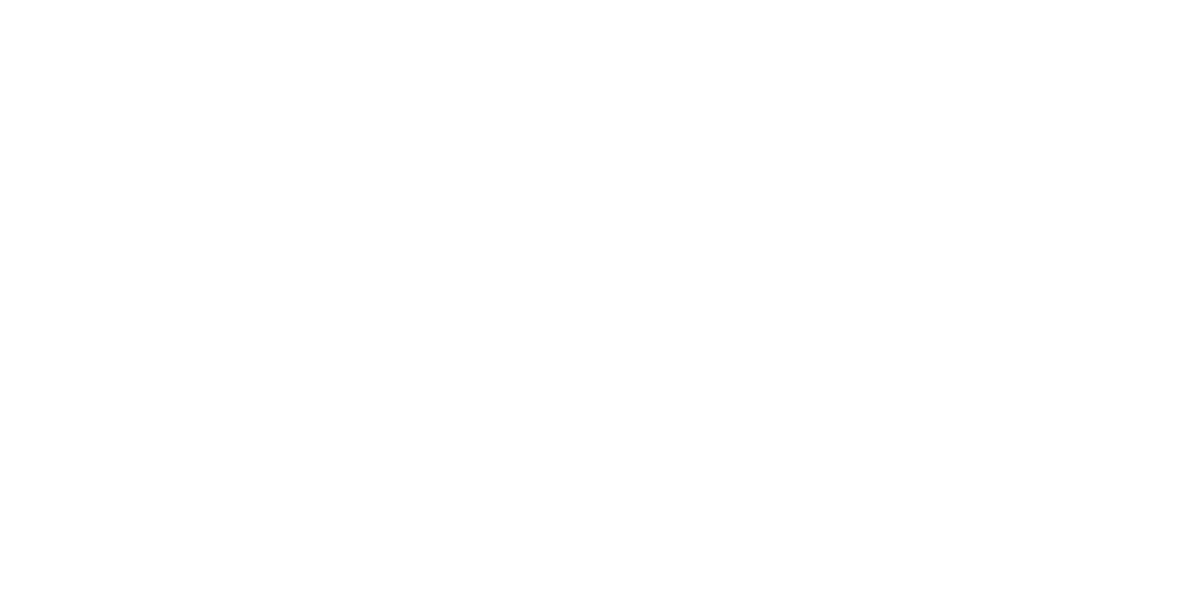

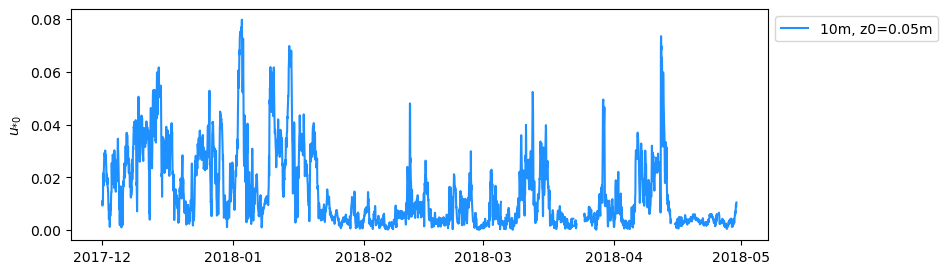

In [1376]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(9,3))

# plt.plot(ds.time, us0[0.05][-30], label='30m, z0=0.05m', c='lightgray')
plt.plot(ds.time, us0[0.05][-10], label='10m, z0=0.05m', c='dodgerblue', )
# plt.plot(ds.time, us0[0.05][-6], label='6m, z0=0.05m', c='darkorange', alpha=0.75)

# ax.set_xlim(datetime(2017,12,1), datetime(2018,4,15))

plt.legend(bbox_to_anchor=(1,1))

plt.ylabel('$u_{*0}$')
# fig.savefig('/Users/mackenziejewell/Desktop/img.png', dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


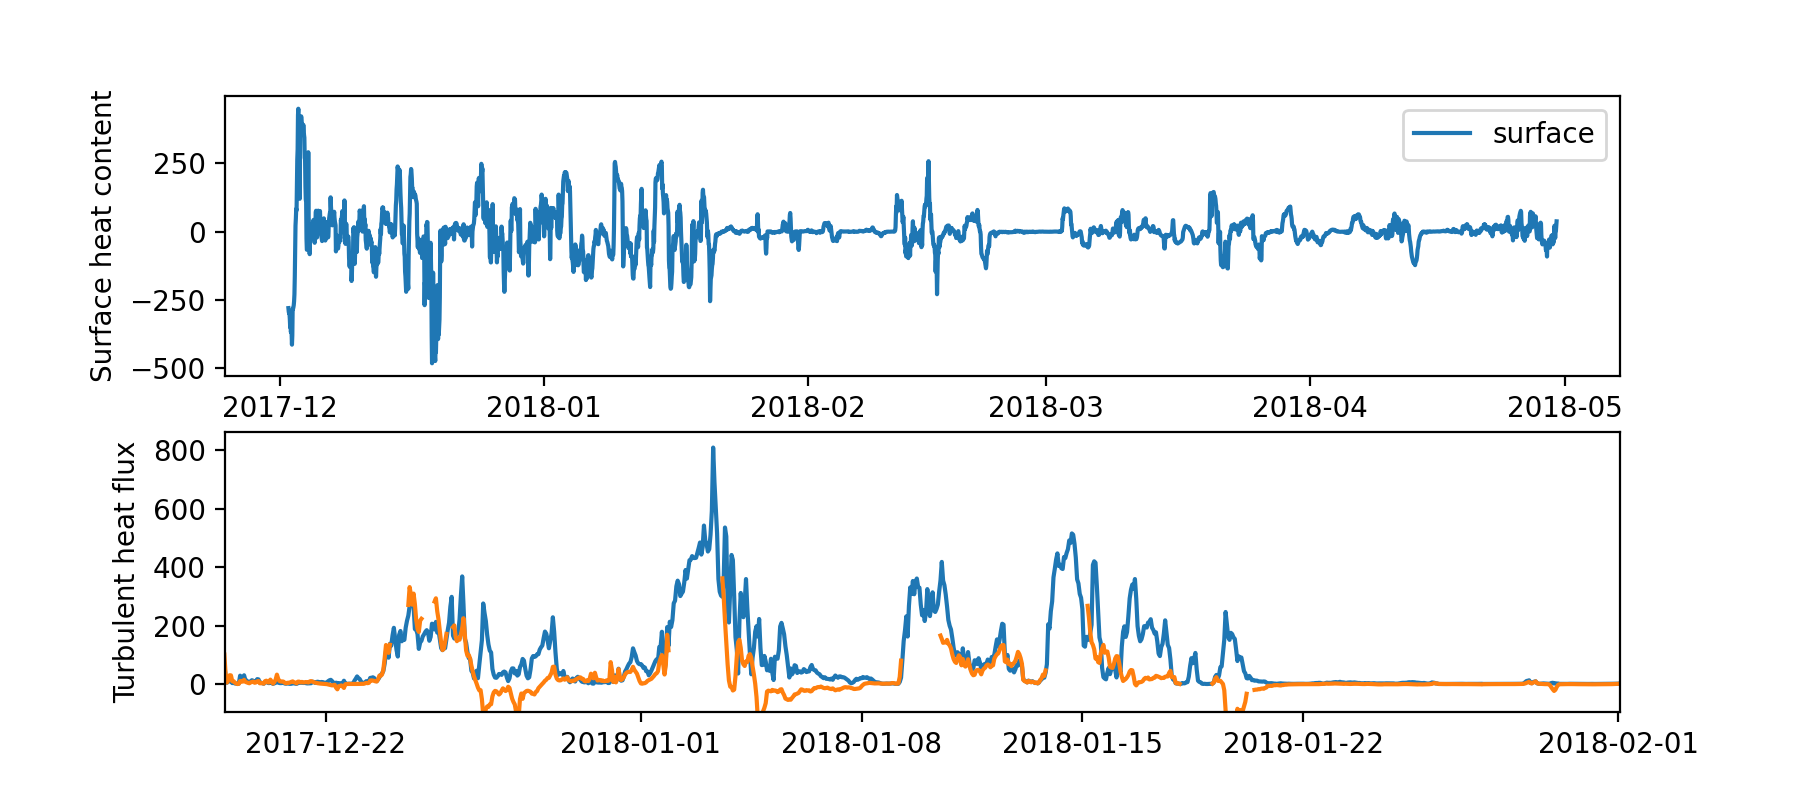

In [1384]:
St = 0.0057

zT = -16

dT = (ds2.sel(depth=zT).Ct - ds2.sel(depth=zT).Tf).values * units('delta_degC')

us = us0[0.05][-10] * units('m/s')

THF = cst['rho_o'] * cst['Cp_o'] * cst['St'] * us * dT

%matplotlib notebook
fig, axs = plt.subplots(2,1,figsize=(9,4))

ax = axs[0]
# ax.plot(ds2.time, OHC[0,:])
lag = 24
ax.plot(ds2.time[lag:], (OHC[0,:][lag:] - OHC[0,:][:-lag])/(lag*60*60), label = 'surface')
ax.legend()
ax.set_ylabel('Surface heat content')


ax = axs[1]
# ax.plot(ds2.time[lag:], (OHC[0,:][lag:] - OHC[0,:][:-lag])/(lag*60*60*units('s')))
ax.plot(ds2.time, 0.5*THF)
ax.set_ylabel('Turbulent heat flux')

ax.plot(ds2.time, (1/3600)*trap_OHT/(16*units('m')))



In [1646]:
wind_angle = vectors.vector_angle(ds4.u10.values, ds4.v10.values)
wind_speed = np.sqrt(ds4.u10.values**2 + ds4.v10.values**2)



wf = 0.15
ta = 20*units('deg')

exp_ice_u = wf * wind_speed * np.cos(wind_angle + ta)
exp_ice_v = wf * wind_speed * np.sin(wind_angle + ta)

exp_ice_se = vectors.comp_along_theta(exp_ice_u, exp_ice_v, 135*units('deg'))





In [1652]:
# 0.2*wind_speed

<IPython.core.display.Javascript object>


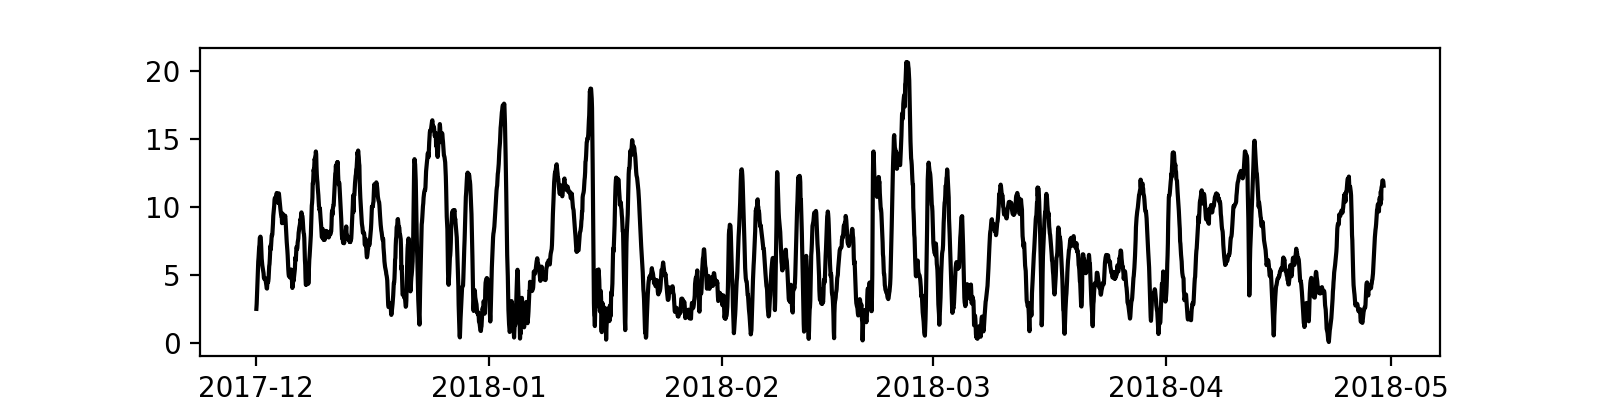

In [1660]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,2))

plt.plot(ds.time, wind_speed, c='k', label='wind')

In [1664]:
2 * (1/0.02)

100.0

<IPython.core.display.Javascript object>


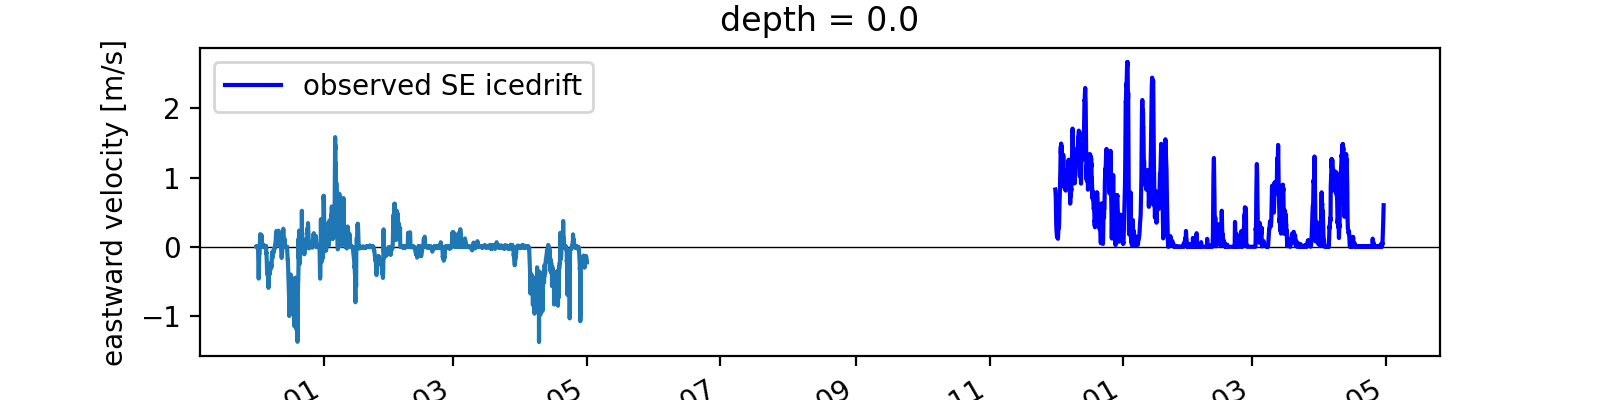

In [1661]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,2))

# plt.plot(ds.time, wind_speed, c='k', label='wind')

# plt.plot(ds.time, exp_ice_se, c='gray', label='expected SE ice drift (wind)')
# plt.plot(ds.time, ma.masked_where(wind_speed<3,np.sqrt(ds3.u**2+ds3.v**2)/wind_speed), c='b', label= 'observed SE icedrift')

plt.plot(ds.time, np.sqrt(ds3.u**2+ds3.v**2), c='b', label= 'observed SE icedrift')

plt.legend()
plt.axhline(0, c='k', zorder=-1, lw=0.5)

# ax2 = ax.twinx()
# ax2.plot(ds2.T.sel(depth=-16), c='r')
# plt.plot(ds4.se)

<IPython.core.display.Javascript object>


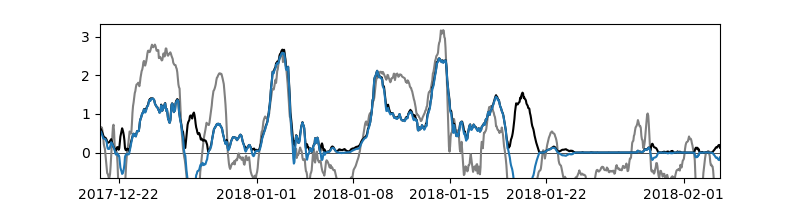

In [1520]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,2))

ax.axhline(0,c='k', zorder=-1, lw=0.5)

# ax.set_xlim(datetime(2017,12,1), datetime(2018,3,1))

# plt.plot(ds.time, 0.2*np.sqrt(ds4.u10**2+ds4.v10**2), c='gray')
plt.plot(ds.time, exp_ice, c='gray')

# plt.plot(ds.time, 0.15*ds4.se_rot20, c='lightgray')
plt.plot(ds.time, np.sqrt(ds3.u**2+ds3.v**2), c='k')

plt.plot(ds.time, ds3.se)

# plt.plot(ds.time, ds.se.sel(depth=-10), c='blue')
# plt.plot(ds.time, icespeed, c='k')




# ds2.dT.sel(depth=-16).plot()
# plt.plot(ds.time[td:], (ds2.dT.sel(depth=-16)[td:]).values-(ds2.dT.sel(depth=-16)[:-td]).values)



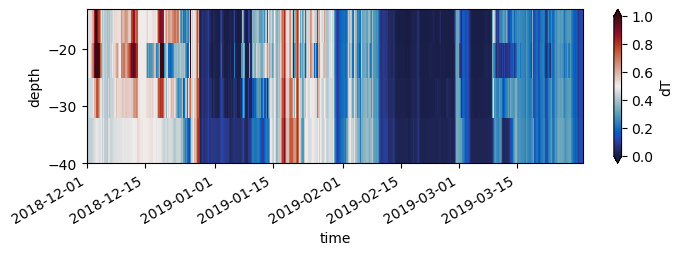

In [1464]:

fig, ax = plt.subplots(figsize=(8,2))

ds2.dT.plot(vmin=0, vmax=1, cmap=cmocean.cm.balance)

In [1440]:
ds2.dT.plot()

In [1404]:
ds2.sel(depth=-16).Ct

<xarray.DataArray 'Ct' (time: 3601)>
[3601 values with dtype=float64]
Coordinates:
    depth    float64 -16.0
  * time     (time) datetime64[ns] 2017-12-01 2017-12-01T01:00:00 ... 2018-04-30
Attributes:
    long_name:  Conservative temperature
    units:      degC

In [1380]:
trap_OHT

<Quantity([22287670.19561567 21728675.68262421 21122584.83847924 ...
  2000277.97990832  3259400.32654066  4518469.92499136], 'joule / meter / second')>